# SCRNN

 ### HANG LI   &  SONG XUE

## Introduction
   Image Super Resolution(SR) is used to make low resolution image upscaled to high resolution output image through some computational things.And there are two types of SR including SR from single image and SR from series of image about same thing.Here we are talking about SR from single image(SISR).<br>

### Part1 Preprocessing
  In this step, the general process is to upscale the LR image from downsampling the original HR image to make the LR image and HR image in the same size.

In [ ]:
!ls Train

In [2]:
import glob
import os
goal_dir = os.path.join(os.getcwd(), "../../my_dir")
print(goal_dir)
path = "/Users/lh/Desktop/Test/"
dirs = os.listdir( path )  #return all files in declare path

# output all files in path
for file in dirs:
   print(file)

/Users/lh/Desktop/Test/../../my_dir
SRCNN.ipynb
.DS_Store
ckpts
SRCNN 1.ipynb
logs
Train
original_image.jpg
.ipynb_checkpoints
  .jpg
data.h5
baby_GT.bmp
_MG_4146.jpg


In [3]:
#   Get image paths from dir
def get_image_paths(dir_path):  #get .bmp file
    dir_path = os.path.join(os.getcwd(), dir_path)
    image_paths = glob.glob(os.path.join(dir_path, '*.bmp'))
    return image_paths

In [4]:
import cv2
import matplotlib.pyplot as plt
imagePath = []
imagePath = get_image_paths('/Users/lh/Desktop/Test/Train/')      #get image path and details
print(len(imagePath))
print(imagePath[0])
im2=cv2.imread(imagePath[0])
print(type(im2))#numpy BGR
print(im2.shape)#[width,height,3]
#print(im2)

91
/Users/lh/Desktop/Test/Train/tt26.bmp
<class 'numpy.ndarray'>
(290, 411, 3)


In [5]:
import numpy as np
def crop(image, scale = 3):  #set the image scale
    height, width = image.shape[0], image.shape[1]
    #.....
    height = height - np.mod(height, scale)
    width = width - np.mod(width, scale)
    image = image[:height, :width]
    return image[0:height,0:width, :]

In [6]:
#    generate lr(low-resolution image) and hr(high-resolution image), then store them in a dataset(.h5 file)
def set_scale(image, scale = 3):

#     image = cv2.imread(imagePath)   
    image = image[:, :, 0:3]
    im_label = crop(image, scale= 3)
    #print(image.shape)
    im_input = cv2.resize(im_label, (0, 0), fx=1.0 / 3, fy=1.0 / 3,interpolation=cv2.INTER_CUBIC)
    im_input = cv2.resize(im_input, (0, 0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    # low resolution for input
    im_input = im_input.astype('float32') / 255.0
    # high resolution for input
    im_label = im_label.astype('float32') / 255.0
    return im_input, im_label        
          
           


In [7]:
#slicing the image to the small pieces in order to get correct database for network
def slicing_image(inp, label, I, L, stride):
    sub_inputs = []
    sub_labels = [] 
    im_label = label
    im_input = inp
    stride = 14
    
    input_size = 33
    label_size = 21
    ## in second SRCNN the parameter 33,21 will be changed to 55,43 when training the second SRCNN
    ## in third SRCNN the parameter 33,21 will be changed to 33,23 when training the second SRCNN
    
    padding = (input_size - label_size) // 2
    (hei, wid, _) = im_label.shape
    for x in range(0, hei - input_size + 1, stride):
        for y in range(0, wid - input_size + 1, stride):
            sub_im_input = im_input[x:x + input_size, y:y + input_size, 0]
            sub_im_label = im_label[x + padding:x + padding + label_size, y + padding: y + padding + label_size,0]
            sub_im_input = sub_im_input.reshape([input_size, input_size, 1])
            sub_im_label = sub_im_label.reshape([label_size, label_size, 1])
            sub_inputs.append(sub_im_input)
            sub_labels.append(sub_im_label)
            
    return sub_inputs, sub_labels

In [8]:
#generate the input file and save it to the root path
import h5py
def make_input():
    inputs = []
    labels = []

    image_paths = get_image_paths('/Users/lh/Desktop/Test/Train/')
    
    for path in image_paths:
        image = cv2.imread(path)
        inp, label = set_scale(image, 3)
        sub_inputs, sub_labels = slicing_image(inp, label, 33, 21, 14)
        ## in second SRCNN the parameter (33,21,14) will be changed to (55,43,14) when training the second SRCNN
        ## in third SRCNN the parameter (33,21,14) will be changed to (33,23,14) when training the second SRCNN
        
        inputs += sub_inputs
        labels += sub_labels

    inputs = np.asarray(inputs) # shape (N, I, I, 1)
    labels = np.asarray(labels) # shape (N, L, L, 1)
    #print(inputs)
    with h5py.File('/Users/lh/Desktop/Test/data.h5', 'w') as hf:
        hf.create_dataset('inputs', data=inputs)
        hf.create_dataset('labels', data=labels)  
    return 0

In [9]:
make_input()

0

In [10]:
#read the .h5 file from root
def read_data(path):
        with h5py.File(path, 'r') as file:
            try:
                inputs = file.get('inputs').value
                labels = file.get('labels').value
                return inputs, labels
            except:
                print('error')

In [11]:
#creating the batch from input and label
def data_iterator(data, label, batch_size=64): 
    num_examples = data.shape[0]
    num_batch = num_examples // batch_size
    num_total = num_batch * batch_size
    while True:
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        shuf_data = data[perm]
        shuf_label = label[perm]
        for i in range(0, num_total, batch_size):
            batch_data = shuf_data[i:i + batch_size]
            batch_label = shuf_label[i:i + batch_size]
            yield batch_data, batch_label

### Part2 Network setup and Training start 
The image processed should act as an input to a one-layer convolutional neural network to extract feature.

In [12]:
#set up the CNN 
import tensorflow as tf 
from tensorflow.contrib import slim
def srcnn(inputs, padding='VALID', name='srcnn'):
    with tf.variable_scope(name):   #initialization parameters
        net = slim.conv2d(inputs, 64, [9, 9], padding=padding, scope='conv1_1')
        ##in third SRCNN, the parameter 9(Convolution kernel) will be change to 7
        
        net = slim.conv2d(net, 32, [1, 1], padding=padding, scope='conv2_1')
        net = slim.conv2d(net, 1, [5, 5], padding=padding, activation_fn=None, scope='conv3_1')
    return net

In [ ]:
#train the dataset
import h5py
import time
def train():
    inputs_placeholder = tf.placeholder('float32', [None, 33, 33, 1])
    true_placeholder = tf.placeholder('float32', [None, 21, 21, 1])
    ## in second SRCNN the parameter 33,21 will be changed to 55,43 when training the second SRCNN
    ## in third SRCNN the parameter 33,21 will be changed to 33,23 when training the second SRCNN

    inference = srcnn(inputs_placeholder, padding='VALID', name='srcnn')

    loss = tf.losses.mean_squared_error(true_placeholder, inference)
    train_op = tf.train.AdamOptimizer(0.1).minimize(loss)

    batch_size = 64
    datasets_path = '/Users/lh/Desktop/Test/data.h5'
    data, label = read_data(datasets_path)
    batch = data_iterator(data, label, batch_size)

    # start session
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print ('start training.....' )
    
    file_path = '/Users/lh/Desktop/Test/logs/'
    # training log route
    if not os.path.exists(file_path):
        os.makedirs(file_path)
    # model saver route
    if not os.path.exists('./ckpts/'):  #check if we have the trained model in the path
        os.makedirs('./ckpts/')
    log = open('/Users/lh/Desktop/Test/logs/' + 'srcnn' + r'_training.logs', mode='a+', encoding='utf-8')
    saver = tf.train.Saver(max_to_keep=200)
    ckpt = tf.train.get_checkpoint_state('./ckpts/')

    if ckpt and ckpt.model_checkpoint_path:
        print('loading')
        saver.restore(sess, ckpt.model_checkpoint_path)

    for i in range(0, 1000):   #train start
        batch_data, batch_label = batch.__next__()
        train_loss, _ = sess.run([loss, train_op],
                                 feed_dict={inputs_placeholder: batch_data, true_placeholder: batch_label})

        if i % 450 == 0:  # print the loss based on setting
            format_time = str(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
            log_info = format_time + ' Epoch [%d] and Loss [%f]' % (i // 450, train_loss)
#             log.writelines(log_info + '\n')
           
            print(log_info +'\n')
        if i % 5000 == 0:  #save the session based on setting
            saver.save(sess, '/Users/lh/Desktop/Test/ckpts/' + 'model_3x.ckpt', i) # save the model
    

In [ ]:
train()

### Part3 Testing and Output compare 
Finally we compare the original HR image and our output image to evaluate the efficiency of the 3-layer CNN built via PSNR

In [13]:
from skimage.measure import compare_psnr,compare_mse
def test(path):
    image = cv2.imread(path)
    image = crop(image, scale = 3)

    # input and ground truth of network
    
    (hei, wid, cha) = image.shape
    im_label = image[:, :, 0]
    im_input = cv2.resize(im_label, (0, 0), fx=1.0 / 3, fy=1.0 / 3, interpolation=cv2.INTER_CUBIC)
    im_input = cv2.resize(im_input, (0, 0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC).astype(np.float32)

    im_Y_label = im_label.reshape((1, hei, wid, 1)).astype(np.float32) / 255.0
    im_Y_input = im_input.reshape((1, hei, wid, 1)).astype(np.float32) / 255.0
    # inference
    inference = srcnn(im_Y_input, padding='SAME', name='srcnn')
    loss = tf.losses.mean_squared_error(im_Y_label, inference)

    # start session
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)

    saver = tf.train.Saver(max_to_keep=2000)
    ckpt = tf.train.get_checkpoint_state('./ckpts/')

    if ckpt and ckpt.model_checkpoint_path:  #first check if the there is a trained model
        print('load model', ckpt.model_checkpoint_path)
        saver.restore(sess, ckpt.model_checkpoint_path)

        test_loss, test_inference = sess.run([loss, inference])

        # test_inference and label should be float32 or compute diff will overflow
        test_inference = test_inference.reshape((test_inference.shape[1], test_inference.shape[2])).astype(dtype=np.uint8)
        
        cv2.imwrite('./original_image.jpg',image)
        image[:, :, 0] = test_inference
        
        cv2.imwrite('./srcnn_result.jpg', image)
        
    
        test_inference = test_inference.astype(np.float32)
        im_Y_label = im_Y_label[0, :, :, 0] * 255.
        
        err = compare_mse(im_Y_label, test_inference)
        psnr_metric = 10 * np.log10((255 ** 2) / err)
        print('PSNR: ' + str(psnr_metric))

In [14]:
test('/Users/lh/Desktop/Test/baby_GT.bmp')

load model /Users/lh/Desktop/Test/ckpts/model_3x.ckpt-0
INFO:tensorflow:Restoring parameters from /Users/lh/Desktop/Test/ckpts/model_3x.ckpt-0
PSNR: 5.939288849192951


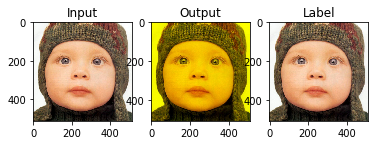

In [15]:
#plot all images
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,3,1)
a = plt.imread('/Users/lh/Desktop/Test/baby_GT.bmp')
plt.title('Input')
plt.imshow(a)
plt.subplot(1,3,2)
b = plt.imread('./srcnn_result.jpg')
plt.title("Output")
plt.imshow(b)
plt.subplot(1,3,3)
c = plt.imread('./original_image.jpg')
plt.title("Label")
plt.imshow(c)   

### Part4 Conclusion 
PSNR is the most common and widely used objective measurement method for evaluating image quality. However, many experimental results show that the PSNR score is not exactly the same as the visual quality seen by the human eyes. It is possible that the higher PSNR looks better than the PSNR while the lower PSNR is worse. This is because the sensitivity of the human eye to the error is not absolute, and the perceived result is affected by many factors (for example, the human eye is more sensitive to the contrast difference of the lower spatial frequency, the human eye is The sensitivity of the brightness contrast difference is higher than the chroma, and the human eye's perception of an area is affected by the surrounding area.